In [1]:
#imports
import pickle, pprint
import math
import netCDF4
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
bm = Basemap()

from matplotlib.gridspec import GridSpec
from scipy import stats
import pandas as pd
from tabulate import tabulate
import xarray as xr
import dask


print('begin')
path_to_file = "/fast/gmooers/Real_Geography_Manuscript/Preprocessed_Data/Summer_Months/full_physics_essentials_valid_month02_targets.nc"
ds = xr.open_dataset(path_to_file)
truths = ds.targets[:, -1].values
#truths = ds.targets.values
lons = ds.lon.values
lats = ds.lat.values

print('halfway')
path_to_file = "/fast/gmooers/Real_Geography_Manuscript/Models/Good_Summer.nc"

ds = xr.open_dataset(path_to_file)
SPERPA_DNN = ds.Prediction[:, -1].values
#SPERPA_DNN = np.squeeze(ds.Prediction.values)


path_to_file = "/fast/gmooers/Real_Geography_Manuscript/Models/Relu_Leaky_Summer_both.nc"
ds = xr.open_dataset(path_to_file)
Constrained_DNN = ds.Prediction[:, -1].values
#Constrained_DNN = ds.Prediction.values

path_to_file = "/fast/gmooers/Real_Geography_Manuscript/Models/SPCAM5_Summer_Months_Output.nc"
ds = xr.open_dataset(path_to_file)
Unconstrained_Unsherpified_DNN = ds.Prediction[:, -1].values
#Unconstrained_Unsherpified_DNN = ds.Prediction.values

path_to_file = "/fast/gmooers/Real_Geography_Manuscript/Models/Summer_3_Months_CAM5.nc"
ds = xr.open_dataset(path_to_file)
CAM_Data = ds.PRECT.values

x = 144
y = 96
z = 30
t = int(len(truths)/(x*y))
print(t)


pkl_file = open('/fast/gmooers/Preprocessed_Data/CAM5_Diurnal.pkl', 'rb')
CAM_Baseline = pickle.load(pkl_file)
pkl_file.close()

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


begin
halfway
8831


In [2]:
print(truths.shape)

(122079744,)


In [3]:
SPCAM5_Truth = np.zeros(shape=(t, y, x))
SHERPA_Pred = np.zeros(shape=(t, y, x))
Costrained_Pred = np.zeros(shape=(t, y, x))
Uncostrained_Pred = np.zeros(shape=(t, y, x))
count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            A = truths[count]
            B = SPERPA_DNN[count]
            C = Constrained_DNN[count]
            D = Unconstrained_Unsherpified_DNN[count]
            SPCAM5_Truth[i, j, k] = A
            SHERPA_Pred[i, j, k] = B
            Costrained_Pred[i, j, k] = C
            Uncostrained_Pred[i, j, k] = D
            count = count + 1
                

In [4]:
lats = lats[::144][:96]
lons = lons[:144]

In [5]:
ny = lats.size
nx = lons.size
nday = int(t/96)
nperday = 96


#Make an empty array of 0's by days, samples in a day, at each lat/lon coord
SPCAM5_data_reorganized = np.zeros(shape=(nday, nperday, ny, nx))
SHERPA_data_reorganized = np.zeros(shape=(nday, nperday, ny, nx))
CONSTRAINED_data_reorganized = np.zeros(shape=(nday, nperday, ny, nx))
UNCONSTRAINED_data_reorganized = np.zeros(shape=(nday, nperday, ny, nx))
CAM_data_reorganized = np.zeros(shape=(nday, nperday, ny, nx))

#loop over the number of days
count = 0
for i in range(len(SPCAM5_data_reorganized)):
    #loop over the samples per day
    for j in range(len(SPCAM5_data_reorganized[0])):
        SPCAM5_data_reorganized[i, j, :, :] = np.squeeze(SPCAM5_Truth[count , :, :])
        SHERPA_data_reorganized[i, j, :, :] = np.squeeze(SHERPA_Pred[count , :, :])
        CONSTRAINED_data_reorganized[i, j, :, :] = np.squeeze(Costrained_Pred[count , :, :])
        UNCONSTRAINED_data_reorganized[i, j, :, :] = np.squeeze(Uncostrained_Pred[count , :, :])
        CAM_data_reorganized[i, j, :, :] = np.squeeze(CAM_Data[count , :, :])
        count = count+1

In [6]:
SPCAM5_themean = np.nanmean(SPCAM5_data_reorganized, axis = 0)
SPCAM5_thestd = np.nanstd(SPCAM5_data_reorganized, axis = 0)

SHERPA_themean = np.nanmean(SHERPA_data_reorganized, axis = 0)
SHERPA_thestd = np.nanstd(SHERPA_data_reorganized, axis = 0)

CONSTRAINED_themean = np.nanmean(CONSTRAINED_data_reorganized, axis = 0)
CONSTRAINED_thestd = np.nanstd(CONSTRAINED_data_reorganized, axis = 0)

UNCONSTRAINED_themean = np.nanmean(UNCONSTRAINED_data_reorganized, axis = 0)
UNCONSTRAINED_thestd = np.nanstd(UNCONSTRAINED_data_reorganized, axis = 0)

CAM_themean = np.nanmean(CAM_data_reorganized, axis = 0)
CAM_thestd = np.nanstd(CAM_data_reorganized, axis = 0)

In [7]:
#make arrays for the required maps
SPCAM5_amplitude_map = np.zeros(shape=(ny, nx))
SPCAM5_phase_map_utc = np.zeros(shape=(ny, nx))
SPCAM5_phase_map_lst = np.zeros(shape=(ny, nx))

SHERPA_amplitude_map = np.zeros(shape=(ny, nx))
SHERPA_phase_map_utc = np.zeros(shape=(ny, nx))
SHERPA_phase_map_lst = np.zeros(shape=(ny, nx))

CONSTRAINED_amplitude_map = np.zeros(shape=(ny, nx))
CONSTRAINED_phase_map_utc = np.zeros(shape=(ny, nx))
CONSTRAINED_phase_map_lst = np.zeros(shape=(ny, nx))

UNCONSTRAINED_amplitude_map = np.zeros(shape=(ny, nx))
UNCONSTRAINED_phase_map_utc = np.zeros(shape=(ny, nx))
UNCONSTRAINED_phase_map_lst = np.zeros(shape=(ny, nx))

CAM_amplitude_map = np.zeros(shape=(ny, nx))
CAM_phase_map_utc = np.zeros(shape=(ny, nx))
CAM_phase_map_lst = np.zeros(shape=(ny, nx))

#get times into UTC
dataset = netCDF4.Dataset("/fast/gmooers/Preprocessed_Data/PRECT_JJA_rcat.nc")

t = np.array(dataset.variables['time'])
utc_hour = (t[:96] - math.floor(t[0]))*24.0-0.125
utc_hour[0] = utc_hour[0]+24

In [8]:
#loop through longitudes
for i in range(len(SPCAM5_data_reorganized[0][0][0])):
    lst_hour = utc_hour +(lons[i]/360.)*24.
    lst_hour[lst_hour > 24] = lst_hour[lst_hour > 24] - 24
    
    #loop through latitudes
    for j in range(len(SPCAM5_data_reorganized[0][0])):
        SPCAM5_precip_cycle = np.squeeze(SPCAM5_themean[:, j, i])
        SPCAM5_amplitude_here = max(SPCAM5_precip_cycle)-min(SPCAM5_precip_cycle)
        SPCAM5_stderr_here = np.squeeze(max(SPCAM5_thestd[:,j,i]))/(math.sqrt(nday/4.0-1.0))
        
        SHERPA_precip_cycle = np.squeeze(SHERPA_themean[:, j, i])
        SHERPA_amplitude_here = max(SHERPA_precip_cycle)-min(SHERPA_precip_cycle)
        SHERPA_stderr_here = np.squeeze(max(SHERPA_thestd[:,j,i]))/(math.sqrt(nday/4.0-1.0))
        
        
        CONSTRAINED_precip_cycle = np.squeeze(CONSTRAINED_themean[:, j, i])
        CONSTRAINED_amplitude_here = max(CONSTRAINED_precip_cycle)-min(CONSTRAINED_precip_cycle)
        CONSTRAINED_stderr_here = np.squeeze(max(CONSTRAINED_thestd[:,j,i]))/(math.sqrt(nday/4.0-1.0))
        
        UNCONSTRAINED_precip_cycle = np.squeeze(UNCONSTRAINED_themean[:, j, i])
        UNCONSTRAINED_amplitude_here = max(UNCONSTRAINED_precip_cycle)-min(UNCONSTRAINED_precip_cycle)
        UNCONSTRAINED_stderr_here = np.squeeze(max(UNCONSTRAINED_thestd[:,j,i]))/(math.sqrt(nday/4.0-1.0))
        
        CAM_precip_cycle = np.squeeze(CAM_themean[:, j, i])
        CAM_amplitude_here = max(CAM_precip_cycle)-min(CAM_precip_cycle)
        CAM_stderr_here = np.squeeze(max(CAM_thestd[:,j,i]))/(math.sqrt(nday/4.0-1.0))
        #avoid high latitudes where unnesesary variation can occur
        
        if SPCAM5_amplitude_here >= 2.0*SPCAM5_stderr_here:
            SPCAM5_amplitude_map[j, i] = SPCAM5_amplitude_here
            if np.std(SPCAM5_precip_cycle) > 0.0:
                index_max = np.argmax(SPCAM5_precip_cycle)
                SPCAM5_phase_map_utc[j, i] = utc_hour[index_max]
                SPCAM5_phase_map_lst[j, i] = lst_hour[index_max]
                
        if SHERPA_amplitude_here >= 2.0*SHERPA_stderr_here:
            SHERPA_amplitude_map[j, i] = SHERPA_amplitude_here
            if np.std(SHERPA_precip_cycle) > 0.0:
                index_max = np.argmax(SHERPA_precip_cycle)
                SHERPA_phase_map_utc[j, i] = utc_hour[index_max]
                SHERPA_phase_map_lst[j, i] = lst_hour[index_max]
                
        if CONSTRAINED_amplitude_here >= 2.0*CONSTRAINED_stderr_here:
            CONSTRAINED_amplitude_map[j, i] = CONSTRAINED_amplitude_here
            if np.std(CONSTRAINED_precip_cycle) > 0.0:
                index_max = np.argmax(CONSTRAINED_precip_cycle)
                CONSTRAINED_phase_map_utc[j, i] = utc_hour[index_max]
                CONSTRAINED_phase_map_lst[j, i] = lst_hour[index_max]
                
        if UNCONSTRAINED_amplitude_here >= 2.0*UNCONSTRAINED_stderr_here:
            UNCONSTRAINED_amplitude_map[j, i] = UNCONSTRAINED_amplitude_here
            if np.std(UNCONSTRAINED_precip_cycle) > 0.0:
                index_max = np.argmax(UNCONSTRAINED_precip_cycle)
                UNCONSTRAINED_phase_map_utc[j, i] = utc_hour[index_max]
                UNCONSTRAINED_phase_map_lst[j, i] = lst_hour[index_max]
        
        if CAM_amplitude_here >= 2.0*CAM_stderr_here:
            CAM_amplitude_map[j, i] = CAM_amplitude_here
            if np.std(CAM_precip_cycle) > 0.0:
                index_max = np.argmax(CAM_precip_cycle)
                CAM_phase_map_utc[j, i] = utc_hour[index_max]
                CAM_phase_map_lst[j, i] = lst_hour[index_max]
                

#generate apropriate lat/lon map
Xvar, Yvar = np.meshgrid(lons, lats)

In [9]:
#add in nans
SPCAM5_nan_map_utc = SPCAM5_phase_map_utc 
SPCAM5_nan_map_lst = SPCAM5_phase_map_lst
for i in range(len(SPCAM5_phase_map_utc)):
    for j in range(len(SPCAM5_phase_map_utc[i])):
        if SPCAM5_phase_map_utc[i][j] == 0.0:
            SPCAM5_nan_map_utc[i][j] = np.nan
            SPCAM5_nan_map_lst[i][j] = np.nan

SHERPA_nan_map_utc = SHERPA_phase_map_utc 
SHERPA_nan_map_lst = SHERPA_phase_map_lst
for i in range(len(SHERPA_phase_map_utc)):
    for j in range(len(SHERPA_phase_map_utc[i])):
        if SHERPA_phase_map_utc[i][j] == 0.0:
            SHERPA_nan_map_utc[i][j] = np.nan
            SHERPA_nan_map_lst[i][j] = np.nan
            
CONSTRAINED_nan_map_utc = CONSTRAINED_phase_map_utc 
CONSTRAINED_nan_map_lst = CONSTRAINED_phase_map_lst
for i in range(len(CONSTRAINED_phase_map_utc)):
    for j in range(len(CONSTRAINED_phase_map_utc[i])):
        if CONSTRAINED_phase_map_utc[i][j] == 0.0:
            CONSTRAINED_nan_map_utc[i][j] = np.nan
            CONSTRAINED_nan_map_lst[i][j] = np.nan

UNCONSTRAINED_nan_map_utc = UNCONSTRAINED_phase_map_utc 
UNCONSTRAINED_nan_map_lst = UNCONSTRAINED_phase_map_lst
for i in range(len(UNCONSTRAINED_phase_map_utc)):
    for j in range(len(UNCONSTRAINED_phase_map_utc[i])):
        if UNCONSTRAINED_phase_map_utc[i][j] == 0.0:
            UNCONSTRAINED_nan_map_utc[i][j] = np.nan
            UNCONSTRAINED_nan_map_lst[i][j] = np.nan
            
CAM_nan_map_utc = CAM_phase_map_utc 
CAM_nan_map_lst = CAM_phase_map_lst
for i in range(len(CAM_phase_map_utc)):
    for j in range(len(CAM_phase_map_utc[i])):
        if CAM_phase_map_utc[i][j] == 0.0:
            CAM_nan_map_utc[i][j] = np.nan
            CAM_nan_map_lst[i][j] = np.nan

In [10]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

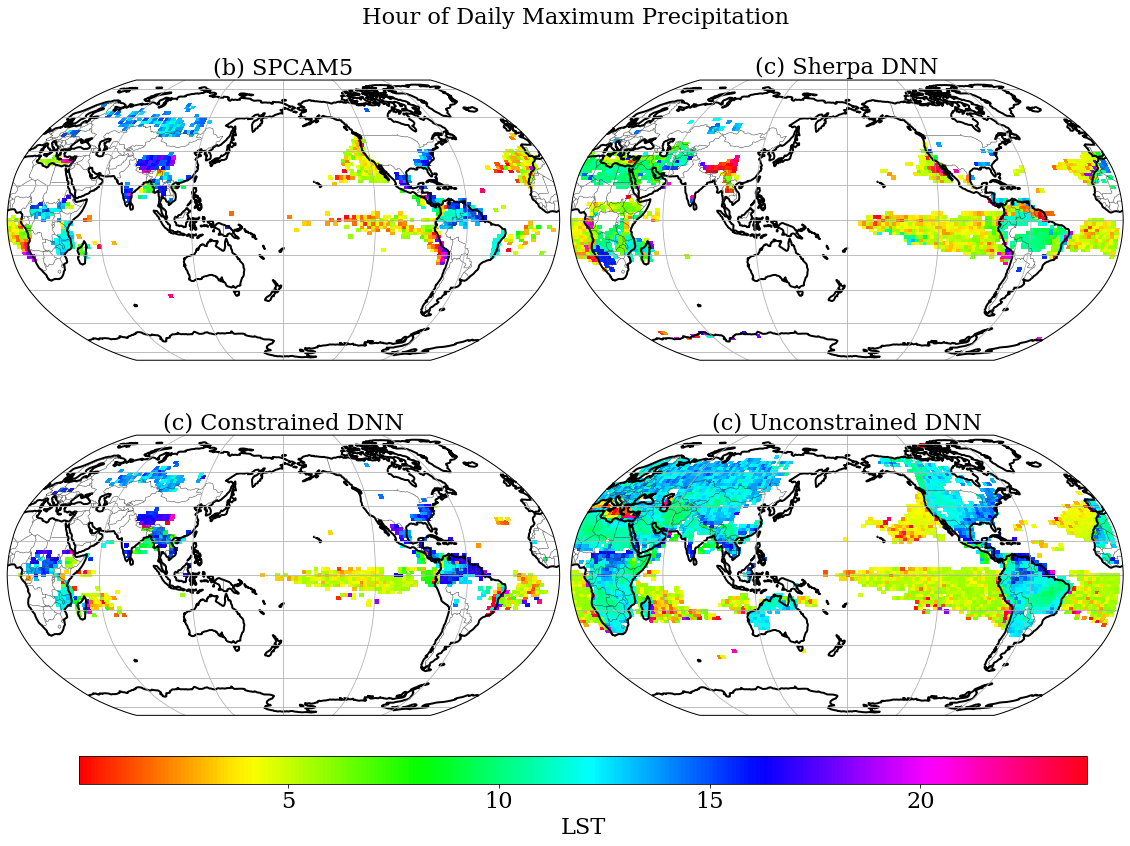

In [11]:
fig, ax = plt.subplots(2,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig.set_size_inches(20,13)

contour_plot = ax[0,0].pcolormesh(Xvar, Yvar, SPCAM5_nan_map_lst,cmap='hsv', transform=ccrs.PlateCarree())
ax[0,0].set_title('(b) SPCAM5', fontsize = fz)
ax[0,0].coastlines(linewidth=2.0,edgecolor='0.25')
ax[0,0].gridlines()
ax[0,0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

contour_plot = ax[0,1].pcolormesh(Xvar, Yvar, SHERPA_nan_map_lst,cmap='hsv', transform=ccrs.PlateCarree())
ax[0,1].set_title('(c) Sherpa DNN', fontsize = fz)
ax[0,1].coastlines(linewidth=2.0,edgecolor='0.25')
ax[0,1].gridlines()
ax[0,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


contour_plot = ax[1,0].pcolormesh(Xvar, Yvar, CONSTRAINED_nan_map_lst,cmap='hsv', transform=ccrs.PlateCarree())
ax[1,0].set_title('(c) Constrained DNN', fontsize = fz)
ax[1,0].coastlines(linewidth=2.0,edgecolor='0.25')
ax[1,0].gridlines()
ax[1,0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

contour_plot = ax[1,1].pcolormesh(Xvar, Yvar, UNCONSTRAINED_nan_map_lst,cmap='hsv', transform=ccrs.PlateCarree())
#plt.colorbar(contour_plot, label = "LST Hour", ax=ax[2])
ax[1,1].set_title('(c) Unconstrained DNN', fontsize = fz)
ax[1,1].coastlines(linewidth=2.0,edgecolor='0.25')
ax[1,1].gridlines()
ax[1,1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

p0 = ax[0,0].get_position().get_points().flatten()
p1 = ax[1,1].get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0]+0.05, 0.09, p1[2]-0.20, 0.03])
plt.colorbar(contour_plot, cax=ax_cbar, orientation='horizontal', label="LST")
plt.subplots_adjust(hspace=0.01, wspace=0.02)
plt.suptitle("Hour of Daily Maximum Precipitation", y=0.92, x=0.52, fontsize = fz)
print(" ")

Text(0.52, 0.92, 'Hour of Daily Maximum Precipitation')

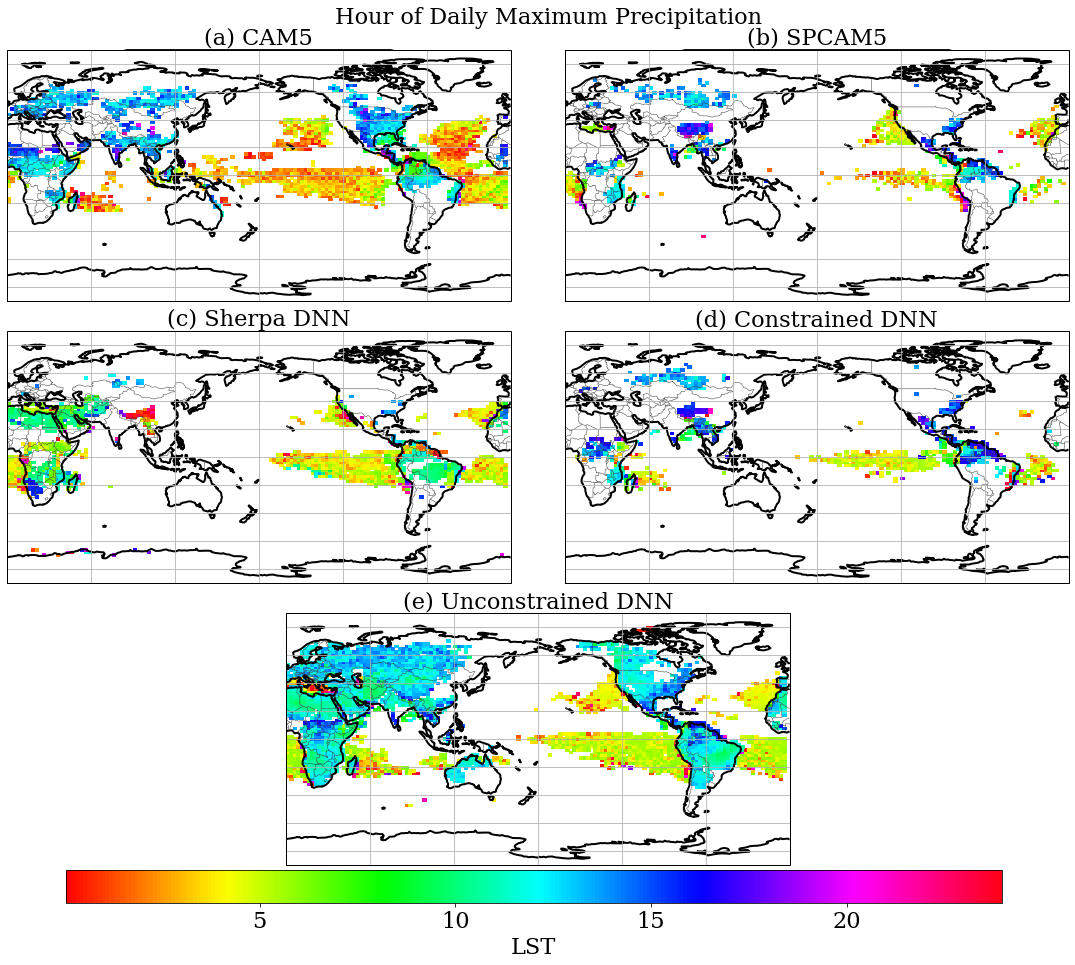

In [12]:
fig, ax = plt.subplots(3,2,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig.set_size_inches(20,15)

gs=GridSpec(3,2) # 2 rows,  columns

ax1=fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree(central_longitude=180)) # First row, first column
ax2=fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree(central_longitude=180)) # First row, second column 
ax3=fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree(central_longitude=180)) # First row, first column
ax4=fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree(central_longitude=180)) # First row, second column 
ax5=fig.add_subplot(gs[2,:],projection=ccrs.PlateCarree(central_longitude=180)) # Second row, span all columns
ax6=fig.add_subplot(gs[2,1],projection=ccrs.PlateCarree(central_longitude=180))

contour_plot = ax1.pcolormesh(Xvar, Yvar, CAM_nan_map_lst, cmap='hsv', transform=ccrs.PlateCarree())
#plt.colorbar(contour_plot, label = "LST Hour", ax=ax[0])
ax1.set_title('(a) CAM5', fontsize = fz)
ax1.coastlines(linewidth=2.0,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

contour_plot = ax2.pcolormesh(Xvar, Yvar, SPCAM5_nan_map_lst,cmap='hsv', transform=ccrs.PlateCarree())
#plt.colorbar(contour_plot, label = "LST Hour")
ax2.set_title('(b) SPCAM5', fontsize = fz)
ax2.coastlines(linewidth=2.0,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

contour_plot = ax3.pcolormesh(Xvar, Yvar, SHERPA_nan_map_lst,cmap='hsv', transform=ccrs.PlateCarree())
#plt.colorbar(contour_plot, label = "LST Hour", ax=ax[2])
ax3.set_title('(c) Sherpa DNN', fontsize = fz)
ax3.coastlines(linewidth=2.0,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


contour_plot = ax4.pcolormesh(Xvar, Yvar, CONSTRAINED_nan_map_lst,cmap='hsv', transform=ccrs.PlateCarree())
#plt.colorbar(contour_plot, label = "LST Hour", ax=ax[2])
ax4.set_title('(d) Constrained DNN', fontsize = fz)
ax4.coastlines(linewidth=2.0,edgecolor='0.25')
ax4.gridlines()
ax4.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

contour_plot = ax5.pcolormesh(Xvar, Yvar, UNCONSTRAINED_nan_map_lst,cmap='hsv', transform=ccrs.PlateCarree())
#plt.colorbar(contour_plot, label = "LST Hour", ax=ax[2])
ax5.set_title('(e) Unconstrained DNN', fontsize = fz)
ax5.coastlines(linewidth=2.0,edgecolor='0.25')
ax5.gridlines()
ax5.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

#ax6.axis('off')
ax6.set_visible(False)
#ax6.clear()
#ax6.remove()
fig.delaxes(ax[2,1])
fig.delaxes(ax[2,0])


p0 = ax1.get_position().get_points().flatten()
p2 = ax1.get_position().get_points().flatten()
ax_cbar = fig.add_axes([p0[0]+0.05, 0.09, p1[2]-0.25, 0.03])
plt.colorbar(contour_plot, cax=ax_cbar, orientation='horizontal', label="LST")
plt.subplots_adjust(hspace=0.12, wspace=0)
plt.suptitle("Hour of Daily Maximum Precipitation", y=0.92, x=0.52, fontsize = fz)

In [17]:
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/LST_PRECIP_CAM.npy", CAM_nan_map_lst)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/LST_PRECIP_SPCAM5.npy", SPCAM5_nan_map_lst)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/LST_PRECIP_SHERPA.npy", SHERPA_nan_map_lst)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/LST_PRECIP_CONSTRAINED.npy", CONSTRAINED_nan_map_lst)
np.save("/fast/gmooers/Real_Geography_Manuscript/Compressed_Data/LST_PRECIP_UNCONSTRAINED.npy", UNCONSTRAINED_nan_map_lst)